<a href="https://colab.research.google.com/github/sanidhyamangal/tensorflow_fashion_mnist/blob/master/Fashion_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fashion MNIST 

This notebooks defines how a CNN can be used to make a classifier which can be used to classify various clothes based on its images. 

Download the Fashion MNIST dataset from https://www.kaggle.com/zalando-research/fashionmnist/downloads/fashionmnist.zip/4

Unzip the files. You should be able to view 2 csv files: fashion-mnist_train.csv and fashion-mnist_test.csv.

## Basic Imports

In [0]:
import numpy as np # for matrix maths 
import itertools # for itertions 
import pandas as pd # for converting data into data tables 
import math # for maths 

# tensorflow import 
import tensorflow as tf 

# DataViz import
import matplotlib.pyplot as plt # for plotting 

## Helper functions

In this section we are going to define some helper functions which are going to help us in formulating problem more easily




### Helper function for prediction 

This is an input function which is used by tensorflow evaluator to predict the image once our model is fully trained.

In [0]:
# helper function for predicting input
def predict_input_fn(df):
    def input_fun():
        
        # seperate pixels from labels 
        pixels = df.iloc[:,1:].as_matrix().astype(float)
        labels = df.iloc[:,0].as_matrix().astype(float)
        
        # construct a tf data set 
        batch_pixels = tf.convert_to_tensor(pixels, tf.float32)
        batch_labels = tf.convert_to_tensor(labels, tf.float32)
        
        return {'pixels':batch_pixels}, batch_labels
    return input_fun

### Helper function for Input 

This section contains a function which perform following operations:

*   Shuffle's data set to increase variance
*   Extract pixels and labels from the Pandas data frame
*   Convert Extracted pixels and labels into tensors and make a one shot iterator

It is a composite function to feed data into tensorflow evaluator.

In [0]:
# def input function 


#@title Boilerplate Code for feeding the dataset into the Model (Can be skipped).

def generate_input_fn(df, batch_size, num_epochs=None):
    def input_fn():

    # shuffle the rows.

        shuffle_df = df.sample(frac=1).reset_index(drop=True)

    # Separate the pixels from the labels.

        pixels = shuffle_df.iloc[:, 1:].as_matrix().astype(float)

        labels = shuffle_df.iloc[:, 0].as_matrix().astype(int)

    # Construct tf.data.DataSet from the 2 numpy arrays.

        pixels = tf.convert_to_tensor(pixels, dtype=tf.float32)

        labels = tf.convert_to_tensor(labels, dtype=tf.int32)

        dataset = tf.data.Dataset.from_tensor_slices((pixels, labels))

        dataset = dataset.shuffle(buffer_size=2 * batch_size + 1)

        dataset = dataset.batch(batch_size)

        dataset = dataset.repeat(num_epochs)

        # make one shot iterator for the data to be feed in evaluator
        iterator = dataset.make_one_shot_iterator()

    

        batch_pixels, batch_labels = iterator.get_next()

    

        return {"pixels": batch_pixels}, batch_labels
    return input_fn

In [4]:
!wget https://gitlab.com/sanidhyamangal/datasets/raw/master/fashion-mnist_train.csv
!wget https://gitlab.com/sanidhyamangal/datasets/raw/master/fashion-mnist_test.csv  

--2019-02-03 05:27:13--  https://gitlab.com/sanidhyamangal/datasets/raw/master/fashion-mnist_train.csv
Resolving gitlab.com (gitlab.com)... 35.231.145.151
Connecting to gitlab.com (gitlab.com)|35.231.145.151|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133047193 (127M) [text/plain]
Saving to: ‘fashion-mnist_train.csv’

fashion-mnist_train 100%[===================>] 126.88M  65.6MB/s    in 1.9s    

2019-02-03 05:27:16 (65.6 MB/s) - ‘fashion-mnist_train.csv’ saved [133047193/133047193]

--2019-02-03 05:27:18--  https://gitlab.com/sanidhyamangal/datasets/raw/master/fashion-mnist_test.csv
Resolving gitlab.com (gitlab.com)... 35.231.145.151
Connecting to gitlab.com (gitlab.com)|35.231.145.151|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 22176691 (21M) [text/plain]
Saving to: ‘fashion-mnist_test.csv’

fashion-mnist_test. 100%[===================>]  21.15M  35.5MB/s    in 0.6s    

2019-02-03 05:27:19 (35.5 MB/s) - ‘fashion-mnist_test

## Analyse Dataset 


Load csv files in a form of pandas data frame

In [0]:
# convert csv to data frames 
train_df = pd.read_csv('./fashion-mnist_train.csv') # train set 
test_df = pd.read_csv('./fashion-mnist_test.csv') # test set 

In [6]:
# describing labels of train set 
train_df.describe()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
count,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,...,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.00000
mean,4.500000,0.000900,0.006150,0.035333,0.101933,0.247967,0.411467,0.805767,2.198283,5.682000,...,34.625400,23.300683,16.588267,17.869433,22.814817,17.911483,8.520633,2.753300,0.855517,0.07025
std,2.872305,0.094689,0.271011,1.222324,2.452871,4.306912,5.836188,8.215169,14.093378,23.819481,...,57.545242,48.854427,41.979611,43.966032,51.830477,45.149388,29.614859,17.397652,9.356960,2.12587
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
50%,4.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
75%,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,58.000000,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
max,9.000000,16.000000,36.000000,226.000000,164.000000,227.000000,230.000000,224.000000,255.000000,254.000000,...,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,170.00000


In [7]:
test_df.describe()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,...,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000
mean,4.500000,0.000400,0.010300,0.052100,0.077000,0.208600,0.349200,0.826700,2.321200,5.457800,...,34.320800,23.071900,16.432000,17.870600,22.860000,17.790200,8.353500,2.541600,0.629500,0.06560
std,2.872425,0.024493,0.525187,2.494315,2.208882,4.669183,5.657849,8.591731,15.031508,23.359019,...,57.888679,49.049749,42.159665,44.140552,51.706601,45.128107,28.765769,16.417363,7.462533,1.93403
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
50%,4.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
75%,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,55.000000,6.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.00000
max,9.000000,2.000000,45.000000,218.000000,185.000000,227.000000,223.000000,247.000000,218.000000,244.000000,...,254.000000,252.000000,255.000000,255.000000,255.000000,255.000000,240.000000,225.000000,205.000000,107.00000


Looks like train set is consists 60k images and test set contains 10k images having 784 pixels i.e is 28 x 28 pixels.

## Usefull Constants for later use

These are the hyperparameters for the CNN.

In [0]:
NUM_CLASSES = 10 # for number of labels classes 
NUM_ROWS = 28 # num for pixels in a row 
NUM_COLS = 28 # num of pixels in a clos 
MAX_PIXEL_VALUE = 255 # highest value of a pixel 
BATCH_SIZE = 64 # batch size for train 
NUM_TRAIN_STEPS = 4000 
NUM_TEST_STEPS = 100

## Plot a sample image for viz

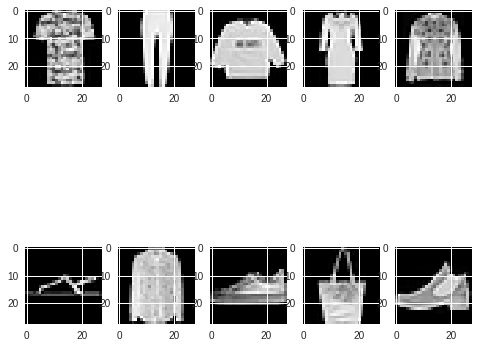

In [9]:
fig = plt.figure(figsize=(8,8))

for label in range(NUM_CLASSES):
    image = train_df[train_df['label'] == label].iloc[0, 1:]
    fig.add_subplot(2, 5, label+1)
    plt.imshow(image.values.reshape(NUM_ROWS, NUM_COLS), cmap='gray', interpolation=None)

# showing a plot 
plt.show()

## Linear Fucntion 

In [0]:
# def linear mode function 
def linear_model_fn(features, labels, mode):
    inputs = features['pixels']
    
    # normalize our inputs for range of 0,1
    normalized_inputs = inputs / MAX_PIXEL_VALUE
    
    # linear layer to directly map to logits 
    logits = tf.layers.dense(normalized_inputs, units=NUM_CLASSES)
    
    # getting predictions 
    predictions = {
        'classes':tf.argmax(input=logits, axis=1),
        'probablities':tf.nn.softmax(logits, name='softmax_tensor')
    }
    
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)
    
    # calculate loss for both train and eval method 
    loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)
    
    # configure function for train op 
    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.AdamOptimizer(learning_rate=1e-4)
        train_op = optimizer.minimize(loss=loss, global_step=tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)
    
    # Add eval metrics for eval operation
    eval_metric_ops = {
        "accuracy":tf.metrics.accuracy(labels=labels, predictions=predictions['classes'])
    }
    
    return tf.estimator.EstimatorSpec(mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)

In [0]:
# setting up logging for our operations 
tensor_to_logs = {'predictions':'softmax_tensor'}
logging_hook = tf.train.LoggingTensorHook(tensors=tensor_to_logs, every_n_iter=50)

In [12]:
#@Train our linear classifier
linear_classifier = tf.estimator.Estimator(model_fn=linear_model_fn)
linear_classifier.train(input_fn=generate_input_fn(train_df,BATCH_SIZE), steps=NUM_TRAIN_STEPS, hooks=None)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_num_ps_replicas': 0, '_keep_checkpoint_max': 5, '_task_type': 'worker', '_global_id_in_cluster': 0, '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f905b097190>, '_model_dir': '/tmp/tmpFVIhGs', '_protocol': None, '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_service': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_tf_random_seed': None, '_save_summary_steps': 100, '_device_fn': None, '_experimental_distribute': None, '_num_worker_replicas': 1, '_task_id': 0, '_log_step_count_steps': 100, '_evaluation_master': '', '_eval_distribute': None, '_train_distribute': None, '_master': ''}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was 

## Evaluate our Model for train and test case 

In [13]:
linear_classifier.evaluate(input_fn=generate_input_fn(train_df, BATCH_SIZE), steps=100)
linear_classifier.evaluate(input_fn=generate_input_fn(test_df, BATCH_SIZE), steps=100)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-02-03-05:29:52
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpFVIhGs/model.ckpt-4000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [10/100]
INFO:tensorflow:Evaluation [20/100]
INFO:tensorflow:Evaluation [30/100]
INFO:tensorflow:Evaluation [40/100]
INFO:tensorflow:Evaluation [50/100]
INFO:tensorflow:Evaluation [60/100]
INFO:tensorflow:Evaluation [70/100]
INFO:tensorflow:Evaluation [80/100]
INFO:tensorflow:Evaluation [90/100]
INFO:tensorflow:Evaluation [100/100]
INFO:tensorflow:Finished evaluation at 2019-02-03-05:29:53
INFO:tensorflow:Saving dict for global step 4000: accuracy = 0.81625, global_step = 4000, loss = 0.56049734
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 4000: /tmp/tmpFVIhGs/model.ckpt-4000
INFO:tensorflow:Calling model_fn.
INFO:tensor

{'accuracy': 0.80671877, 'global_step': 4000, 'loss': 0.59339595}

We can see that our model with linear layer produces an accuracy of around ~81%

## CNN for image classifier

In [0]:
# make a func for cnn cls 
def cnn_model_fn(features, labels, mode):
    """Model function for CNN."""
    
    # inputs 
    inputs = tf.reshape(features['pixels'], [-1, NUM_ROWS, NUM_COLS, 1])
    
    # normalized inputs 
    normalized_inputs = inputs / MAX_PIXEL_VALUE
    
    # making a conv layer 1 
    conv1 = tf.layers.conv2d(inputs=normalized_inputs, filters=32, kernel_size=[3,3],padding='same', activation=tf.nn.relu)
    
    # making a pooling layer 1 
    pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2,2], strides=2)
    
    # making a conv layer 2
    conv2 = tf.layers.conv2d(inputs=pool1, filters=64, kernel_size=[3,3], padding='same', activation=tf.nn.relu)
    
    # making a pooling layer 2
    pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2,2], strides=2)
    
    # a full dense layer 
    pool2_flat = tf.reshape(pool2, [-1, 7*7*64]) # making pool2 layer flat 
    
    dense = tf.layers.dense(inputs=pool2_flat, units=1024, activation=tf.nn.relu)
    
    # a drop out layer with 40% 
    dropout = tf.layers.dropout(inputs=dense, rate=0.4, training=mode == tf.estimator.ModeKeys.TRAIN)
    
    # final logits linear layer 
    logits = tf.layers.dense(inputs=dropout, units=NUM_CLASSES)
    # getting predictions for eval and predict method 
    predictions = {
        "classes":tf.argmax(input=logits, axis=1),
        "probablities":tf.nn.softmax(logits=logits, name="softmax_tesor")
    }
    
    # if mode prediction
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode= mode, predictions=predictions)
    
    # computing loss for our model 
    loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)
    
    # for train mode 
    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.AdamOptimizer(learning_rate=1e-4)
        train_op = optimizer.minimize(loss = loss, global_step = tf.train.get_global_step())
        
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op = train_op)
    
    # for eval mode 
    eval_metric_ops = {
        "accuracy":tf.metrics.accuracy(labels=labels, predictions=predictions['classes'])
    }
    
    return tf.estimator.EstimatorSpec(mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)

In [15]:
# train our cnn model 
cnn_classifier = tf.estimator.Estimator(model_fn=cnn_model_fn)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_num_ps_replicas': 0, '_keep_checkpoint_max': 5, '_task_type': 'worker', '_global_id_in_cluster': 0, '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f8ff21e0e90>, '_model_dir': '/tmp/tmp7RsQTc', '_protocol': None, '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_service': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_tf_random_seed': None, '_save_summary_steps': 100, '_device_fn': None, '_experimental_distribute': None, '_num_worker_replicas': 1, '_task_id': 0, '_log_step_count_steps': 100, '_evaluation_master': '', '_eval_distribute': None, '_train_distribute': None, '_master': ''}


In [16]:
cnn_classifier.train(input_fn=generate_input_fn(train_df, BATCH_SIZE), steps=NUM_TRAIN_STEPS, hooks=None)

KeyboardInterrupt: ignored

In [0]:
# making eval for train and test case 
cnn_classifier.evaluate(input_fn=generate_input_fn(train_df, BATCH_SIZE), steps=100) # for train set 
cnn_classifier.evaluate(input_fn=generate_input_fn(test_df, BATCH_SIZE), steps=100) # for test set

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:15: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  from ipykernel import kernelapp as app
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:17: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-09-10-06:54:18
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpd_RjPj/model.ckpt-4000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [10/100]
INFO:tensorflow:Evaluation [20/100]
INFO:tensorflow:Evaluation [30/100]
INFO:tensorflow:Evaluation [40/100]
INFO:tensorflow:Evaluation [50/100]
INFO:tensorflow:Evaluation [60/100]
INFO:tensorflow:Evaluation [70/100]
INFO:tensorflow:Evaluation [80/100]
INFO:tensorflow:Evaluation [90/100]
INFO:tensorflow:Evaluation [100/100]
INFO:tensorflow:Finished evaluation at 2018-09-10-06:54:23
INFO:tensorflow:Saving dict for global step 4000: accuracy = 0.9021875, global_step = 4000, loss = 0.2782911
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 4000: /tmp/tmpd_RjPj/model.ckpt-4000
INFO:tensorflow:Calling model_fn.
INFO:tenso

{'accuracy': 0.8996875, 'global_step': 4000, 'loss': 0.28847972}